# PostgreSQL with Python Advanced

This is the study note written by __Siyu Yao (April)__ on 220815 - 220820.

Focus on following things:
- WITH clause, CTE (common table expression)
- Recursion clause
- Case clause
- Tree
    - `parent_id` column vs. `ltree` module
- Link PostgreSQL with python ORM and Pandas.
    - Peewee: warp sql statement with class, more secure and so on
    - SQLAlchemy: same as Peewee
    - Pandas: useful when need data visualization

## Set UP

Link the pgdb use psycopg2 and create the table needed in this note.

In [1]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

In [2]:
#import library work with PostgreSQL
import psycopg2
import psycopg2.extras        # used for context manager, see below

#the needed information for link db, can be found in postico login page

hostname = 'localhost'
database = 'mydb'
username = 'i52'
pwd = ''
port_id = 5432

#to record connection and cursor statement, see later

conn = None
cur = None

#link to database
conn = psycopg2.connect(host = hostname,
                        dbname = database,
                        user = username,
                        password = pwd,
                        port = port_id)

#create a 'cursor' object for actually working with queries

cur = conn.cursor()     #normal way
#cur = conn.cursor(cursor_factory = psycopg2.extras.DictCursor)     #in dictionary from

print('Database connected.\n')

Database connected.



In [3]:
#drop before create to avoid duplicate in multi-time practice execute
# cur.execute('DROP VIEW IF EXISTS myview')

# print('View dropped.\n')

#drop before create to avoid duplicate in multi-time practice execute
cur.execute('DROP TABLE IF EXISTS employee')
# cur.execute('DROP TABLE IF EXISTS department')
# cur.execute('DROP TABLE IF EXISTS manager')
# cur.execute('DROP TABLE IF EXISTS projects')
cur.execute('DROP TABLE IF EXISTS family')
cur.execute('DROP TYPE IF EXISTS sexes;')



#create table
cur.execute('''CREATE TYPE sexes AS ENUM ('F', 'M')''')
create_script = '''CREATE TABLE IF NOT EXISTS employee(     --only create if the table not created before
                        emp_id      varchar(20) PRIMARY KEY,
                        name        varchar(50) NOT NULL,
                        sex         sexes,
                        salary      int,                    -- inside is part of SQL, comment style change
                        dept_id     varchar(20),
                        manager_id  varchar(20)
                        )'''       #same syntax as in SQL
#execute the change
cur.execute(create_script)

create_script = '''CREATE TABLE IF NOT EXISTS family(
                        member_id varchar(10),
                        name      varchar(50),
                        age       int,
                        parent_id varchar(10));'''
cur.execute(create_script)


#insert date into db
insert_script = '''INSERT INTO employee (emp_id, name, sex, salary, dept_id, manager_id)
                    VALUES (%s, %s, %s, %s, %s, %s)'''
insert_values = [('E1', 'James', 'M', 8000, 'D1', 'M1'), ('E2', 'Bob', 'M', 9500, 'D1', 'M1'), 
                ('E3', 'Eva', 'F', 7000, 'D1', 'M2'), ('E4', 'Jack', 'M', 13000, 'D1', 'M2'),
                ('E5', 'Robin', 'M', 20000,'D10', 'M3'), ('E6', 'Amy', 'F', 15000, 'D10', 'M3'),
                ('E7', 'May', 'F', 5000, 'D3', 'M3')]


for value in insert_values:
        cur.execute(insert_script, value)

        
insert_script = '''INSERT INTO family(member_id, name, age, parent_id)
                     VALUES(%s, %s, %s, %s)'''
insert_values = [('F1', 'David', 4, 'F5'), ('F2', 'Carol', 10, 'F5'),
                 ('F3', 'Michael', 12,  'F5'),('F4', 'Johnson', 36, None), 
                 ('F5', 'Maryam', 40, 'F6'),('F6', 'Stewart', 70, None), 
                 ('F7', 'Rohan', 6, 'F4'),('F8', 'Asha', 8, 'F4')]
for value in insert_values:
        cur.execute(insert_script, value)
        

cur.execute('SELECT * FROM employee')
print('------- Table employee -------')
for record in cur.fetchall():
    print(record)     #one at a line in tuple        

cur.execute('SELECT * FROM family')
print('\n------- Table family -------')
for record in cur.fetchall():
    print(record)
    
conn.commit()

------- Table employee -------
('E1', 'James', 'M', 8000, 'D1', 'M1')
('E2', 'Bob', 'M', 9500, 'D1', 'M1')
('E3', 'Eva', 'F', 7000, 'D1', 'M2')
('E4', 'Jack', 'M', 13000, 'D1', 'M2')
('E5', 'Robin', 'M', 20000, 'D10', 'M3')
('E6', 'Amy', 'F', 15000, 'D10', 'M3')
('E7', 'May', 'F', 5000, 'D3', 'M3')

------- Table family -------
('F1', 'David', 4, 'F5')
('F2', 'Carol', 10, 'F5')
('F3', 'Michael', 12, 'F5')
('F4', 'Johnson', 36, None)
('F5', 'Maryam', 40, 'F6')
('F6', 'Stewart', 70, None)
('F7', 'Rohan', 6, 'F4')
('F8', 'Asha', 8, 'F4')


## WITH & CTE/ Sub-Query Factoring

A WITH clause can also be referred to as CTE(stands for common table expression) also referred to as Sub-Query Factoring. They basically mean the same.

SQL query not only start with SELECT clause, can also start with WITH clause. WITH clause has to before main SELECT statement.

SQL syntax:<br>
`WITH alias/function_name (list of columns that will be returned) as <br>
    (query/function_body)<br>
main SELECT statement`



Task: Fetch employees who earn more than average salary of all employees.

In [4]:
with_script = ''' WITH average_salary (avg_sal) AS
                            (SELECT CAST(AVG(salary) AS int) FROM employee)      -- like a temporary table named average_salary which has one column named avg_sal, but SQL do not actually store data or create table
                    SELECT * FROM employee e, average_salary av                  -- main statement
                    WHERE e.salary > av.avg_sal;
                    '''     

cur.execute(with_script)

for record in cur.fetchall():
    print(record) 

('E4', 'Jack', 'M', 13000, 'D1', 'M2', 11071)
('E5', 'Robin', 'M', 20000, 'D10', 'M3', 11071)
('E6', 'Amy', 'F', 15000, 'D10', 'M3', 11071)


## Recursion

SQL syntax:<br>
`WITH RECURSIVE CTE_name AS
    (
    SELECT query (Non Recursive query or Base query)   -- base case
    UNION [ALL]
    SELECT query (RECURSIVE query using CTE_name [with a termination condition])    -- recursive
    )
 SELECT * FROM CTE_name;`
    

How recursive query works: first execute base case, then keep execute recursive step until termination condition is FALSE. Just like what recursive should work in other language.

Tasks:
1. Display successive numbers.
    - Display number from 1 to 10 without using any in build functions.
2. Get all child nodes from a parent node.
    - Find the family relationship/ hierarchy of children under a given parent "Stewart".
3. Get all parent nodes from a child node.
    - Find the the family relationship/ hierarchy of parents for a given child "David".

In [5]:
# task1
task1_script = ''' WITH RECURSIVE numbers AS
                    (
                    SELECT 1 AS n                        -- base case
                    UNION ALL
                    SELECT n+1 FROM numbers WHERE n<10   -- recursive
                    )
                    SELECT * FROM numbers;
               '''     

cur.execute(task1_script)
print(cur.fetchall()) 

[(1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (10,)]


In [6]:
# task2
task2_script = ''' WITH RECURSIVE family_relationship AS
                    (
                    SELECT f.member_id, f.name, f.parent_id, 1 AS level FROM family f WHERE name = 'Stewart'    -- base case
                    UNION
                    SELECT f.member_id, f.name, f.parent_id, fr.level+1 AS level 
                        FROM family_relationship fr JOIN family f ON fr.member_id = f.parent_id   -- recursive
                    )
                    SELECT fr.member_id, fr.name, f.name AS parent_name, fr.level
                        FROM family_relationship fr LEFT JOIN family f ON f.member_id = fr.parent_id
                        ORDER BY fr.level;
                '''
cur.execute(task2_script)

for record in cur.fetchall():
    print(record) 

('F6', 'Stewart', None, 1)
('F5', 'Maryam', 'Stewart', 2)
('F3', 'Michael', 'Maryam', 3)
('F2', 'Carol', 'Maryam', 3)
('F1', 'David', 'Maryam', 3)


In [7]:
# task3
task3_script1 = ''' WITH RECURSIVE family_relationship2 AS
                    (
                    SELECT member_id, name, parent_id, 1 AS level FROM family WHERE name = 'David'
                    UNION ALL
                    SELECT f.member_id, f.name, f.parent_id, fr2.level+1 AS level
                        FROM family_relationship2 fr2 JOIN family f ON fr2.parent_id = f.member_id 
                    )
                    SELECT fr2.member_id, fr2.name, fr2.parent_id, f.name, level
                    FROM family_relationship2 fr2 LEFT JOIN family f ON fr2.parent_id = f.member_id ;
                '''
# can use LEFT JOIN in main statement as task2 did
cur.execute(task3_script1)

print('------ Use LEFT JOIN in main statement ------')
for record in cur.fetchall():
    print(record)

task3_script2 = ''' WITH RECURSIVE family_relationship2 AS
                    (
                    SELECT child.member_id, child.name, child.parent_id, parent.name AS parent_name, 1 AS level
                        FROM family child JOIN family parent ON child.parent_id = parent.member_id AND child.name = 'David'
                    UNION ALL
                    SELECT f.member_id, f.name, f.parent_id, parent.name, fr2.level+1 AS level
                        FROM family_relationship2 fr2 JOIN family f ON fr2.parent_id = f.member_id 
                        LEFT JOIN family parent ON f.parent_id = parent.member_id
                    )

                    SELECT *
                    FROM family_relationship2;
                '''
#also can use SELF JOIN from base case
cur.execute(task3_script2)

print('\n------ Use self JOIN from base case ------')
for record in cur.fetchall():
    print(record) 

------ Use LEFT JOIN in main statement ------
('F1', 'David', 'F5', 'Maryam', 1)
('F5', 'Maryam', 'F6', 'Stewart', 2)
('F6', 'Stewart', None, None, 3)

------ Use self JOIN from base case ------
('F1', 'David', 'F5', 'Maryam', 1)
('F5', 'Maryam', 'F6', 'Stewart', 2)
('F6', 'Stewart', None, None, 3)


## CASE

The SQL CASE expression is a generic conditional expression, similar to if/else statements in other programming languages:<br>
`CASE WHEN condition THEN result
     [WHEN ...]
     [ELSE result]
END`

Tasks:
1. Calculate the bonus for each employee. If an employee's salary is not a multiple of 400 and his name does not begin with a 'B', then his bonus is 50% of his salary, otherwise his bonus is 10%. Ordered by emp_id.
2. Use only one UPDATE statement and no SELECT statement, no intermediate temporary table to swap employees' sex (i.e. all 'F' to 'M' and all 'M' to 'F').

In [8]:
case1_script = '''SELECT emp_id, name, salary, 
                    CASE WHEN (salary%400!=0 AND LEFT(name, 1) != 'B' )THEN CAST(salary*0.5 AS int)
                        ELSE CAST(salary*0.1 AS int)
                    END AS bonus
                FROM employee
                ORDER BY emp_id;
                '''
cur.execute(case1_script)

for record in cur.fetchall():
    print(record) 

('E1', 'James', 8000, 800)
('E2', 'Bob', 9500, 950)
('E3', 'Eva', 7000, 3500)
('E4', 'Jack', 13000, 6500)
('E5', 'Robin', 20000, 2000)
('E6', 'Amy', 15000, 7500)
('E7', 'May', 5000, 2500)


In [9]:
print('\n------ Before update ------')
cur.execute('SELECT name, sex FROM employee')
for record in cur.fetchall():
    print(record) 


case2_script = '''UPDATE employee SET sex = 
                    (CASE sex WHEN 'F' THEN 'M'::sexes ELSE CAST('F' AS sexes) END);
                '''
# if not add ::sexes/ CAST then wil get ERROR:  column "sex" is of type sexes but expression is of type text
cur.execute(case2_script)


print('\n------ After update ------')
cur.execute('SELECT name, sex FROM employee')
for record in cur.fetchall():
    print(record) 


------ Before update ------
('James', 'M')
('Bob', 'M')
('Eva', 'F')
('Jack', 'M')
('Robin', 'M')
('Amy', 'F')
('May', 'F')

------ After update ------
('James', 'F')
('Bob', 'F')
('Eva', 'M')
('Jack', 'F')
('Robin', 'F')
('Amy', 'M')
('May', 'M')


## Tree

The most common and obvious way is to have some kind of `parent_id` column on table that references itself. For query this type of tree, see 'Recursion' task 2 and 3.<br>
Also can use [`ltree`](https://www.postgresql.org/docs/current/ltree.html) module `CREATE EXTENSION ltree;` to create labels of data stored in a hierarchical tree-like structure. A *label path* is a sequence of zero or more labels separated by dots, for example L1.L2.L3, representing a path **from the root of a hierarchical tree to a particular node**.

Task:
1. Write an SQL query to report the type of each node in the family tree. Return the result table ordered by id in ascending order. Each node in the tree can be one of three types: (1) "Leaf": if the node is a leaf node. (2)"Root": if the node is the root of the tree. (3)"Inner": If the node is neither a leaf node nor a root node.
2. Get all child nodes from a parent node.
    - Find the tree hierarchy of child node under a node 3.
3. Get all parent nodes from a child node.
    - Find the the tree hierarchy of parent nodes for a given leaf node 6.

In [10]:
cur.execute('DROP TABLE IF EXISTS tree')
cur.execute('DROP EXTENSION IF EXISTS ltree;')

# create tree with ltree module
cur.execute('CREATE EXTENSION IF NOT EXISTS ltree;')

create_tree = '''CREATE TABLE IF NOT EXISTS tree(
                    id    int PRIMARY KEY,
                    name  text,
                    parent_path ltree)
              '''   
cur.execute(create_tree)

create_index = '''CREATE INDEX parent_path_idx 
                  ON tree 
                  USING GIST (parent_path);   -- GIST stands for Generalized Search Tree
              '''   
cur.execute(create_index)    # index is like pointer to db data



insert_tree = '''INSERT INTO tree (id, name, parent_path)
                    VALUES (%s, %s, %s)'''
insert_nodes = [(1, 'Intro', 'root'), (2, 'Section 1', 'root.2'),
                (3, 'Section 1.1', 'root.2.3'),(4, 'Section 2', 'root.4'), 
                (5, 'Section 2.1', 'root.4.5'),(6, 'Section 2.2', 'root.4.6'), 
                (7, 'Section 2.2.1', 'root.4.6.7')]


for node in insert_nodes:
        cur.execute(insert_tree, node)

In [11]:
#task1
tree1_script = '''SELECT member_id,
                    CASE WHEN parent_id IS NULL THEN 'Root'
                        WHEN member_id IN (SELECT parent_id FROM family) THEN 'Inner'
                        ELSE 'Leaf'
                    END AS type
                FROM family
                ORDER BY member_id;
                '''
cur.execute(tree1_script)

for record in cur.fetchall():
    print(record) 

('F1', 'Leaf')
('F2', 'Leaf')
('F3', 'Leaf')
('F4', 'Root')
('F5', 'Inner')
('F6', 'Root')
('F7', 'Leaf')
('F8', 'Leaf')


In [12]:
# task2
tree2_script = ''' SELECT * FROM tree WHERE parent_path <@ 'root.4';
                '''   # @ will match case-insensitively, for example a@ matches A
cur.execute(tree2_script)

for record in cur.fetchall():
    print(record) 

(4, 'Section 2', 'root.4')
(5, 'Section 2.1', 'root.4.5')
(6, 'Section 2.2', 'root.4.6')
(7, 'Section 2.2.1', 'root.4.6.7')


In [13]:
# task3
tree3_script = ''' SELECT * FROM tree WHERE parent_path @> 'root.4.6.7';
                '''   # @ will match case-insensitively, for example a@ matches A
cur.execute(tree3_script)

for record in cur.fetchall():
    print(record) 

(1, 'Intro', 'root')
(4, 'Section 2', 'root.4')
(6, 'Section 2.2', 'root.4.6')
(7, 'Section 2.2.1', 'root.4.6.7')


## Disconnect Database

In [14]:
#close the connection if connect success
if cur is not None:
    cur.close()
if conn != None:
    conn.close()
print("Connection closed!")

Conncetion closed!


## Python ORM
ORM(Object-Relational Mappers), a code library that automates the transfer of data stored in relational database tables into objects that are more commonly used in application code.

ORM pros:
- Safer way to deal with database.
- Write Python code instead of SQL statements to CRUD.
- Speed up web application development, not having to switch from Python code into writing declarative paradigm SQL statements.
- Theoretically possible to switch an application between various relational databases with minimal code modifications.

ORM cons:
- Potential for reduced performance.
- Shifting complexity from the database into the application code.

## Peewee

Compared with using `psycopg2`, `peewee` wrap SQL statement around classes, avoid directly modify data and given more security.

**Model Definition**
Model classes, fields and model instances all map to database concepts:

|Object	|Corresponds to…|
|:-------|:---------------|
|Model class|	Database table|
|Field instance	|Column on a table|
|Model instance	|Row in a database table|


### Connect to db and create table

In [15]:
from peewee import *

hostname = 'localhost'
database = 'peewee_test'
username = 'i52'
pwd = ''
port_id = 5432

db = PostgresqlDatabase(database, host=hostname, port=port_id, user=username, password=pwd)

In [16]:
# same as: CREATE TABLE person ( id SERIAL PRIMARY KEY, name character varying(255) NOT NULL, birthday date NOT NULL);
class Person(Model):
    name = CharField()
    birthday = DateField()

    class Meta:
        database = db # This model uses the "peewee_test.db" database.




# same as: CREATE TABLE pet ( id SERIAL PRIMARY KEY, owner_id integer NOT NULL REFERENCES person(id), name character varying(255) NOT NULL, animal_type character varying(255) NOT NULL);
class Pet(Model):
    owner = ForeignKeyField(Person, backref='pets')
    name = CharField()
    animal_type = CharField()

    class Meta:
        database = db # this model uses the "peewee_test.db" database

In [17]:
# connect to the database
db.connect()

# create the tables 
db.create_tables([Person, Pet])

# run query from terminal

# peewee_test=# SELECT column_name, data_type FROM information_schema.columns WHERE table_name = 'person' ;
#  column_name |     data_type     
# -------------+-------------------
#  id          | integer
#  birthday    | date
#  name        | character varying
# (3 rows)
# peewee_test=# SELECT column_name, data_type FROM information_schema.columns WHERE table_name = 'pet';
#  column_name |     data_type     
# -------------+-------------------
#  id          | integer
#  owner_id    | integer
#  name        | character varying
#  animal_type | character varying
# (4 rows)

### Insert data

In [18]:
from datetime import date

# same as: INSERT INTO person VALUES (1, 'Bob', '1960-01-15')
uncle_bob = Person(name='Bob', birthday=date(1960, 1, 15))
uncle_bob.save() # bob is now stored in the database

# Returns: 1, When you call save(), the number of rows modified is returned.

1

In [19]:
# can also add a person by calling the create() method, which returns a model instance
grandma = Person.create(name='Grandma', birthday=date(1935, 3, 1))
herb = Person.create(name='Herb', birthday=date(1950, 5, 5))

bob_kitty = Pet.create(owner=uncle_bob, name='Kitty', animal_type='cat')
herb_fido = Pet.create(owner=herb, name='Fido', animal_type='dog')
herb_mittens = Pet.create(owner=herb, name='Mittens', animal_type='cat')
herb_mittens_jr = Pet.create(owner=herb, name='Mittens Jr', animal_type='cat')

### Delete data

In [20]:
herb_mittens.delete_instance() # he had a great life
# Returns: 1, The return value of delete_instance() is the number of rows removed from the database.

1

### Update data

In [21]:
# To update a row, modify the model instance and call save() to persist the changes.
grandma.name = 'Grandma L.'
grandma.save()  # Update grandma's name in the database.

1

In [22]:
herb_fido.owner = uncle_bob
herb_fido.save()   # Update uncle Bob adopts Herb’s Fido in the database.

1

### Select data

In [23]:
# To get a single record from the database, use Select.get():
grandma = Person.select().where(Person.name == 'Grandma L.').get()
print('---- Model.select.where.get(): SELECT * FROM person WHERE name = \'Grandma L.\' ----')
print(grandma.id, grandma.name, grandma.birthday)

# can also use the equivalent shorthand Model.get():
grandma = Person.get(Person.name == 'Grandma L.')
print('\n---- Model.get(): SELECT id FROM person WHERE name = \'Grandma L.\' ----')
print(grandma)

---- Model.select.where.get(): SELECT * FROM person WHERE name = 'Grandma L.' ----
2 Grandma L. 1935-03-01

---- Model.get(): SELECT id FROM person WHERE name = 'Grandma L.' ----
2


In [24]:
# Get list of record from database
print('---- Model.select(): SELECT * FROM person ----')
for person in Person.select():
    print(person.id, person.name, person.birthday)

---- Model.select(): SELECT * FROM person ----
1 Bob 1960-01-15
3 Herb 1950-05-05
2 Grandma L. 1935-03-01
4 Bob 1960-01-15
6 Herb 1950-05-05
5 Grandma L. 1935-03-01


In [25]:
query = (Pet
         .select(Pet, Person)
         .join(Person)
         .where(Pet.animal_type == 'cat'))

print('---- SELECT p.name, pr.name FROM pet p JOIN person pr ON p.owner_id = pr.id WHERE p.animal_type = \'cat\' ----')
for pet in query:
    print(pet.name, pet.owner.name)

---- SELECT p.name, pr.name FROM pet p JOIN person pr ON p.owner_id = pr.id WHERE p.animal_type = 'cat' ----
Kitty Bob
Mittens Jr Herb
Kitty Bob
Mittens Jr Herb


In [26]:
print('---- select.join.where(): SELECT p.name FROM pet p JOIN person pr ON p.owner_id = pr.id WHERE pr.name = \'Bob\' ----')
for pet in Pet.select().join(Person).where(Person.name == 'Bob'):
    print(pet.name)
    
# since there is already have an object to represent Bob, we can do this instead:
print('\n---- select.where(): SELECT p.name FROM pet p JOIN person pr ON p.owner_id = pr.id WHERE pr.name = \'Bob\' ----')
for pet in Pet.select().where(Pet.owner == uncle_bob):
    print(pet.name)

---- select.join.where(): SELECT p.name FROM pet p JOIN person pr ON p.owner_id = pr.id WHERE pr.name = 'Bob' ----
Kitty
Fido
Kitty
Fido

---- select.where(): SELECT p.name FROM pet p JOIN person pr ON p.owner_id = pr.id WHERE pr.name = 'Bob' ----
Kitty
Fido


### Sorting data/ Order by

In [27]:
print('---- SELECT p.name FROM pet p JOIN person pr ON p.owner_id = pr.id WHERE pr.name = \'Bob\' ORDER BY p.name ----')
for pet in Pet.select().where(Pet.owner == uncle_bob).order_by(Pet.name):
    print(pet.name)
    

print('\n---- SELECT name, birthday FROM person ORDER BY birthday desc')
for person in Person.select().order_by(Person.birthday.desc()):
    print(person.name, person.birthday)

---- SELECT p.name FROM pet p JOIN person pr ON p.owner_id = pr.id WHERE pr.name = 'Bob' ORDER BY p.name ----
Fido
Kitty

---- SELECT name, birthday FROM person ORDER BY birthday desc
Bob 1960-01-15
Bob 1960-01-15
Herb 1950-05-05
Herb 1950-05-05
Grandma L. 1935-03-01
Grandma L. 1935-03-01


### Combining filter expressions / AND OR

In [28]:
d1940 = date(1940, 1, 1)
d1960 = date(1960, 1, 1)
query = (Person
         .select()
         .where((Person.birthday < d1940) | (Person.birthday > d1960)))

print('---- SELECT name, birthday FROM person WHERE birthday<\'1940-01-01\' OR birthday>\'1960-01-01\'')
for person in query:
    print(person.name, person.birthday)
    
query = (Person
         .select()
         .where(Person.birthday.between(d1940, d1960)))

print('\n---- SELECT name, birthday FROM person WHERE birthday>\'1940-01-01\' AND birthday<\'1960-01-01\'')
for person in query:
    print(person.name, person.birthday)

---- SELECT name, birthday FROM person WHERE birthday<'1940-01-01' OR birthday>'1960-01-01'
Bob 1960-01-15
Grandma L. 1935-03-01
Bob 1960-01-15
Grandma L. 1935-03-01

---- SELECT name, birthday FROM person WHERE birthday>'1940-01-01' AND birthday<'1960-01-01'
Herb 1950-05-05
Herb 1950-05-05


### Aggregates and Prefetch

In [29]:
query = (Person
         .select(Person, fn.COUNT(Pet.id).alias('pet_count'))
         .join(Pet, JOIN.LEFT_OUTER)  # include people without pets.
         .group_by(Person)
         .order_by(Person.name))

# Peewee provides a magical helper fn(), which can be used to call any SQL function. 
# In the above example, fn.COUNT(Pet.id).alias('pet_count') would be translated into COUNT(pet.id) AS pet_count.


print('---- SELECT pr.name, COUNT(p.id) AS pet_count \nFROM person pr LEFT JOIN pet p ON p.owner_id = pr.id GROUP BY pr.name ORDER BY pr.name ----\n')
for person in query:
    # "pet_count" becomes an attribute on the returned model instances.
    print(person.name, person.pet_count, 'pets')

---- SELECT pr.name, COUNT(p.id) AS pet_count 
FROM person pr LEFT JOIN pet p ON p.owner_id = pr.id GROUP BY pr.name ORDER BY pr.name ----

Bob 2 pets
Bob 2 pets
Grandma L. 0 pets
Grandma L. 0 pets
Herb 1 pets
Herb 1 pets


In [30]:
query = (Person
         .select(Person, Pet)
         .join(Pet, JOIN.LEFT_OUTER)
         .order_by(Person.name, Pet.name))

print('---- SELECT pr.name, \n\tCASE WHEN p.name is NULL  THEN \'no pets\' ELSE p.name END\n     FROM person pr LEFT JOIN pet p ON p.owner_id = pr.id ORDER BY pr.name, p.name ----\n')

for person in query:
    # We need to check if they have a pet instance attached, since not all
    # people have pets.
    if hasattr(person, 'pet'):
        print(person.name, person.pet.name)
    else:
        print(person.name, 'no pets')

        
# can use a special method called prefetch():
query = Person.select().order_by(Person.name).prefetch(Pet)
print('\n---- prefetch() ----')
for person in query:
    print(person.name)
    for pet in person.pets:
        print('  *', pet.name)

---- SELECT pr.name, 
	CASE WHEN p.name is NULL  THEN 'no pets' ELSE p.name END
     FROM person pr LEFT JOIN pet p ON p.owner_id = pr.id ORDER BY pr.name, p.name ----

Bob Fido
Bob Fido
Bob Kitty
Bob Kitty
Grandma L. no pets
Grandma L. no pets
Herb Mittens Jr
Herb Mittens Jr

---- prefetch() ----
Bob
  * Kitty
  * Fido
Bob
  * Kitty
  * Fido
Grandma L.
Grandma L.
Herb
  * Mittens Jr
Herb
  * Mittens Jr


### SQL Functions

In [31]:
expression = fn.Lower(fn.Substr(Person.name, 1, 1)) == 'g'

print('---- SELECT name FROM person WHERE LOWER(SUBSTR(name, 1, 1)) = \'g\'')
for person in Person.select().where(expression):
    print(person.name)

---- SELECT name FROM person WHERE LOWER(SUBSTR(name, 1, 1)) = 'g'
Grandma L.
Grandma L.


### Close connection

In [32]:
db.close()

True

### Working with existing databases

In [33]:
# # in terminal, use the following command to convert an existing databases to a python file
# # $ python3 -m pwiz -e postgresql my_postgres_db > output_python_file.py

# # eg: $ python3 -m pwiz -e postgresql mydb > peewee_module.py


# # the result from peewee_module.py

# from peewee import *

# database = PostgresqlDatabase('mydb')

# class UnknownField(object):
#     def __init__(self, *_, **__): pass

# class BaseModel(Model):
#     class Meta:
#         database = database

# class Department(BaseModel):
#     dept_id = CharField(null=True)
#     dept_name = CharField(null=True)

#     class Meta:
#         table_name = 'department'
#         primary_key = False

# class Employee(BaseModel):
#     dept_id = CharField(null=True)
#     emp_id = CharField(primary_key=True)
#     manager_id = CharField(null=True)
#     name = CharField()
#     salary = IntegerField(null=True)
#     sex = UnknownField(null=True)  # USER-DEFINED

#     class Meta:
#         table_name = 'employee'

# class Family(BaseModel):
#     age = IntegerField(null=True)
#     member_id = CharField(null=True)
#     name = CharField(null=True)
#     parent_id = CharField(null=True)

#     class Meta:
#         table_name = 'family'
#         primary_key = False

# class Manager(BaseModel):
#     dept_id = CharField(null=True)
#     manager_id = CharField(null=True)
#     manager_name = CharField(null=True)

#     class Meta:
#         table_name = 'manager'
#         primary_key = False

# class Projects(BaseModel):
#     project_id = CharField(null=True)
#     project_name = CharField(null=True)
#     team_member_id = CharField(null=True)

#     class Meta:
#         table_name = 'projects'
#         primary_key = False

# class Tree(BaseModel):
#     name = TextField(null=True)
#     parent_path = UnknownField(index=True, null=True)  # USER-DEFINED

#     class Meta:
#         table_name = 'tree'

## SQLAlchemy

SQLAlchemy offers cleaner code, more secure code, simpler logic than raw SQL approach. Instead of having to think on a table, row, and column level, we can consider everything on a class, instance, and attribute level.

There are three levels for using SQLAlchemy:
1. Using only SQLAlchemy's engine component to execute raw SQL.
2. Using SQLAlchemy's expression language to build SQL statements in a more Pythonic way than using raw SQL strings.
3. Using SQLAlchemy's full Object Relational Mapping (ORM) capabilities which allows one to think in terms of Python classes and objects instead of database tables and connections.

Following code will focus on how to run each of the CRUD operations on each level and there differences.

### Using Raw SQL

Using this method, none of the above advantages are used, and we may as well use only a basic Python database driver (e.g. psycopg).

In [34]:
from sqlalchemy import create_engine

pgsql = { 'hostname': 'localhost',
            'database' : 'sqlalchemy_test',
            'username' : 'i52',
            'pwd' : '',
            'port_id' : 5432
        }

db_string = "postgresql://{username}:{pwd}@{hostname}:{port_id}/{database}".format(**pgsql)

db = create_engine(db_string)

db.execute("DROP TABLE IF EXISTS films")

# Create 
db.execute("CREATE TABLE IF NOT EXISTS films (title text, director text, year text)") 
db.execute("INSERT INTO films (title, director, year) VALUES ('Doctor Strange', 'Scott Derrickson', '2016')")
db.execute("INSERT INTO films (title, director, year) VALUES ('Harry Potter', 'Raw', '2008')")

# Read
print('---- Read ----')
result_set = db.execute("SELECT * FROM films")  
for r in result_set:  
    print(r)

# Update
print('---- Update ----')
db.execute("UPDATE films SET title='Some2016Film' WHERE year='2016'")
result_set = db.execute("SELECT * FROM films")  
for r in result_set:  
    print(r)

# Delete
print('---- Delete ----')
db.execute("DELETE FROM films WHERE year='2016'")
result_set = db.execute("SELECT * FROM films")  
for r in result_set:  
    print(r)
    

# Disconnect
db.dispose()

---- Read ----
('Doctor Strange', 'Scott Derrickson', '2016')
('Harry Potter', 'Raw', '2008')
---- Update ----
('Harry Potter', 'Raw', '2008')
('Some2016Film', 'Scott Derrickson', '2016')
---- Delete ----
('Harry Potter', 'Raw', '2008')


### Using the SQL Expression Language

Code is a little bit more verbose, and also fairly complicated and difficult to read, so we don't gain that much over the raw SQL queries above. But we're already starting to get closer to interacting with our database in a pythonic way.

- C: `.create() .insert() .values() `
- R: `.select() .where()`
- U: `.update() .where() .values()`
- D: `.delete() .where()`

In [35]:
from sqlalchemy import create_engine  
from sqlalchemy import Table, Column, String, MetaData

pgsql = { 'hostname': 'localhost',
            'database' : 'sqlalchemy_test',
            'username' : 'i52',
            'pwd' : '',
            'port_id' : 5432
        }

db_string = "postgresql://{username}:{pwd}@{hostname}:{port_id}/{database}".format(**pgsql)

db = create_engine(db_string)

db.execute("DROP TABLE IF EXISTS films")

meta = MetaData(db)  
film_table = Table('films', meta,  
                       Column('title', String),
                       Column('director', String),
                       Column('year', String))

with db.connect() as conn:
    # Create
    film_table.create()
    insert_statement = film_table.insert().values(title="Doctor Strange", director="Scott Derrickson", year="2016")
    conn.execute(insert_statement)
    insert_statement = film_table.insert().values(title="Harry Potter", director="Language", year="2008")
    conn.execute(insert_statement)

    # Read
    select_statement = film_table.select()
    result_set = conn.execute(select_statement)
    print('---- Read ----')
    for r in result_set:
        print(r)

    # Update
    update_statement = film_table.update().where(film_table.c.year=="2016").values(title = "Some2016Film")
    conn.execute(update_statement)
    print('---- Update ----')
    for r in conn.execute(film_table.select()):
        print(r)

    # Delete
    delete_statement = film_table.delete().where(film_table.c.year == "2016")
    conn.execute(delete_statement)
    print('---- Delete ----')
    for r in conn.execute(film_table.select()):
        print(r)
        
# Disconnect
db.dispose()

---- Read ----
('Doctor Strange', 'Scott Derrickson', '2016')
('Harry Potter', 'Language', '2008')
---- Update ----
('Harry Potter', 'Language', '2008')
('Some2016Film', 'Scott Derrickson', '2016')
---- Delete ----
('Harry Potter', 'Language', '2008')


### Using the SQL ORM

Code is now longer again in terms of lines, but more concise in terms of line length, and it is more readable. At this point, we can largely ignore database concepts such as tables, and think only in terms of Python objects.

In [36]:
from sqlalchemy import create_engine  
from sqlalchemy import Column, String  
from sqlalchemy.ext.declarative import declarative_base  
from sqlalchemy.orm import sessionmaker

pgsql = { 'hostname': 'localhost',
            'database' : 'sqlalchemy_test',
            'username' : 'i52',
            'pwd' : '',
            'port_id' : 5432
        }

db_string = "postgresql://{username}:{pwd}@{hostname}:{port_id}/{database}".format(**pgsql)

db = create_engine(db_string)  
base = declarative_base()

class Film(base):  
    __tablename__ = 'films'

    title = Column(String, primary_key=True)
    director = Column(String)
    year = Column(String)

# Session: intelligent connection to database 
# will watch Python code and modify the database as necessary
Session = sessionmaker(db)  
session = Session()


base.metadata.drop_all(db)
base.metadata.create_all(db)

# Create 
doctor_strange = Film(title="Doctor Strange", director="Scott Derrickson", year="2016")
harry_potter = Film(title="Harry Potter", director="ORM", year="2008")
session.add(doctor_strange)
session.add(harry_potter)
session.commit()    # commit the change

# Read
print('---- Read ----')
films = session.query(Film)  
for film in films:  
    print(film.title, film.director)

# Update
print('---- Update ----')
doctor_strange.title = "Some2016Film"  
session.commit()
films = session.query(Film)  
for film in films:
    print(film.title, film.director)

# Delete
print('---- Delete ----')
session.delete(doctor_strange)  
session.commit()  
films = session.query(Film)  
for film in films:
    print(film.title, film.director)
    
# Disconnect
db.dispose()

---- Read ----
Doctor Strange Scott Derrickson
Harry Potter ORM
---- Update ----
Harry Potter ORM
Some2016Film Scott Derrickson
---- Delete ----
Harry Potter ORM


## Pandas

Use pandas and other modules to analyze PostgreSQL data in Python. Including:
- Write pandas dataframe into PostgreSQL
- Read from PostgreSQL data to pandas DataFrame
- Visualize PostgreSQL Data

### Write pandas dataframe into PostgreSQL

i.e. Create PostgreSQL Database from Pandas DataFrame<br>
`DataFrame.to_sql(name, con, schema=None, if_exists=’fail’, index=True,index_label=None, chunksize=None, dtype=None, method=None)`

In [37]:
import pandas
from sqlalchemy import create_engine, inspect


pgsql = { 'hostname': 'localhost',
            'database' : 'sqlalchemy_test',
            'username' : 'i52',
            'pwd' : '',
            'port_id' : 5432
        }

db_string = "postgresql://{username}:{pwd}@{hostname}:{port_id}/{database}".format(**pgsql)

db = create_engine(db_string)

db.execute("DROP TABLE IF EXISTS gapminder")
print('Before: ', inspect(db).get_table_names())

# read csv data from url and store the resultset in a DataFrame.
data_frame = pandas.read_csv("https://raw.githubusercontent.com/kirenz/datasets/master/gapminder.csv")

# use db to write the pandas data into PostgreSQL database and call the table 'gapminder'
data_frame.to_sql('gapminder', db, if_exists='replace')

# check table exist
print('After: ', inspect(db).get_table_names())

db.dispose()

Before:  ['films']
After:  ['films', 'gapminder']


### Read from PostgreSQL data to pandas DataFrame

Data from a PostgreSQL table can be read and loaded into a pandas DataFrame by calling the method `DataFrame.read_sql()` and passing the database connection obtained from the SQLAlchemy Engine as a parameter.

In [38]:
import pandas
from sqlalchemy import create_engine

pgsql = { 'hostname': 'localhost',
            'database' : 'sqlalchemy_test',
            'username' : 'i52',
            'pwd' : '',
            'port_id' : 5432
        }

db_string = "postgresql://{username}:{pwd}@{hostname}:{port_id}/{database}".format(**pgsql)

db = create_engine(db_string)

# read data from db table and load into a DataFrame
data_frame = pandas.read_sql("SELECT * FROM gapminder ", db);

# set display format: If the width exceeds' display.width ', the output will not wrap across multiple 'pages'.
pandas.set_option('display.expand_frame_repr', False);

# print the DataFrame
print(data_frame);

db.dispose()

      index      country continent  year  lifeExp       pop   gdpPercap
0         0  Afghanistan      Asia  1952   28.801   8425333  779.445314
1         1  Afghanistan      Asia  1957   30.332   9240934  820.853030
2         2  Afghanistan      Asia  1962   31.997  10267083  853.100710
3         3  Afghanistan      Asia  1967   34.020  11537966  836.197138
4         4  Afghanistan      Asia  1972   36.088  13079460  739.981106
...     ...          ...       ...   ...      ...       ...         ...
1699   1699     Zimbabwe    Africa  1987   62.351   9216418  706.157306
1700   1700     Zimbabwe    Africa  1992   60.377  10704340  693.420786
1701   1701     Zimbabwe    Africa  1997   46.809  11404948  792.449960
1702   1702     Zimbabwe    Africa  2002   39.989  11926563  672.038623
1703   1703     Zimbabwe    Africa  2007   43.487  12311143  469.709298

[1704 rows x 7 columns]


### Visualize PostgreSQL Data

Read PostgreSQL data using `read_sql()`, then use `matplotlib` to visualize data.

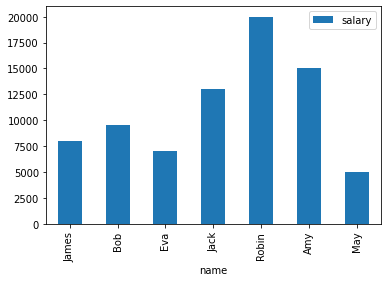

In [39]:
import pandas
import matplotlib.pyplot as plt
from sqlalchemy import create_engine


pgsql = { 'hostname': 'localhost',
            'database' : 'mydb',
            'username' : 'i52',
            'pwd' : '',
            'port_id' : 5432
        }

db_string = "postgresql://{username}:{pwd}@{hostname}:{port_id}/{database}".format(**pgsql)

db = create_engine(db_string)

# execute SQL statement and store the resultset in a DataFrame.
data_frame = pandas.read_sql("SELECT name, salary FROM employee", db)

# build a chart to display data. show() will display the chart in a new window.
data_frame.plot(kind="bar", x="name", y="salary")
plt.show()

db.dispose()